## Create confound regressors

1. Use Freesurfer segmentation to create white matter and CSF regressors
2. Save into /conf/ subfolder
3. TBD- add global signal and derivatives

In [1]:
# Import nilearn and numpy
from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn import image
from nilearn import masking
import numpy as np
import pandas as pd
import glob
from nilearn import signal
from scipy import stats
import nibabel as nib
import glob
import os
%matplotlib inline
import matplotlib.pyplot as plt
# install nsdcode by cloning the repository and following the instructions:
# https://github.com/cvnlab/nsdcode/
from nsdcode.nsd_mapdata import NSDmapdata
from nsdcode.nsd_datalocation import nsd_datalocation
from nsdcode.nsd_output import nsd_write_fs
from nsdcode.utils import makeimagestack

In [3]:
# List all paths
basedir ='/scratch/groups/jyeatman/NSD/ppdata/'
fsdir = '/scratch/groups/jyeatman/NSD/nsddata/freesurfer/'
analysisdir = os.path.dirname(os.path.dirname((basedir))) + '/analysis/'
nsd_path = '/scratch/groups/jyeatman/NSD/'
nsd = NSDmapdata(nsd_path)

In [4]:
# Set parameters
clobber = False
subs = ['subj01','subj02','subj03','subj04','subj05','subj06','subj07','subj08']
doPlot= True

In [5]:
# aseg.nii.gz labels: from nsddata/templates/FreeSurferColorLUT.txt
# 2 --> Left-Cerebral-White-Matter
# 41 --> Right-Cerebral-White-Matter
# 24 --> CSF
# 4 --> Left-Lateral-Ventricle
# 14 -->3rd-Ventricle
# 15 --> 4th-Ventricle
# 43 --> Right-Lateral-Ventricle

Loading /scratch/groups/jyeatman/NSD/nsddata/ppdata/subj05/func1pt8mm/aseg.nii.gz
Found 20 runs for sub subj05
Loading run: /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/timeseries/timeseries_session21_run01.nii.gz
Applying WM mask
White matter timepoints by voxels:
(226, 59647)
Applying CSF mask
CSF timepoints by voxels:
(226, 162)

Saving : /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/conf/conf_session21_run01.tsv
Loading run: /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/timeseries/timeseries_session21_run14.nii.gz
Applying WM mask
White matter timepoints by voxels:
(226, 59647)
Applying CSF mask
CSF timepoints by voxels:
(226, 162)

Saving : /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/conf/conf_session21_run14.tsv
Loading run: /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/timeseries/timeseries_session22_run01.nii.gz
Applying WM mask
White matter timepoints by voxels:
(226, 59647)
Applying CSF mask
CSF timepoints by voxels:
(226, 162)

Savi

/tmp/ipykernel_26260/3454628936.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize =(4, 3))


Applying WM mask
White matter timepoints by voxels:
(226, 59647)
Applying CSF mask
CSF timepoints by voxels:
(226, 162)

Saving : /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/conf/conf_session30_run01.tsv
Loading run: /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/timeseries/timeseries_session30_run14.nii.gz
Applying WM mask
White matter timepoints by voxels:
(226, 59647)
Applying CSF mask
CSF timepoints by voxels:
(226, 162)

Saving : /scratch/groups/jyeatman/NSD/ppdata/subj05/func1pt8mm/conf/conf_session30_run14.tsv
Loading /scratch/groups/jyeatman/NSD/nsddata/ppdata/subj06/func1pt8mm/aseg.nii.gz
Found 20 runs for sub subj06
Loading run: /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/timeseries/timeseries_session21_run01.nii.gz
Applying WM mask
White matter timepoints by voxels:
(226, 87914)
Applying CSF mask
CSF timepoints by voxels:
(226, 159)

Saving : /scratch/groups/jyeatman/NSD/ppdata/subj06/func1pt8mm/conf/conf_session21_run01.tsv
Loading run: /scratch/g

Applying WM mask
White matter timepoints by voxels:
(226, 61315)
Applying CSF mask
CSF timepoints by voxels:
(226, 140)

Saving : /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/conf/conf_session22_run14.tsv
Loading run: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/timeseries/timeseries_session23_run01.nii.gz
Applying WM mask
White matter timepoints by voxels:
(226, 61315)
Applying CSF mask
CSF timepoints by voxels:
(226, 140)

Saving : /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/conf/conf_session23_run01.tsv
Loading run: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/timeseries/timeseries_session23_run14.nii.gz
Applying WM mask
White matter timepoints by voxels:
(226, 61315)
Applying CSF mask
CSF timepoints by voxels:
(226, 140)

Saving : /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/conf/conf_session23_run14.tsv
Loading run: /scratch/groups/jyeatman/NSD/ppdata/subj07/func1pt8mm/timeseries/timeseries_session24_run01.nii.gz
Applying WM mask
White

Applying WM mask
White matter timepoints by voxels:
(226, 69186)
Applying CSF mask
CSF timepoints by voxels:
(226, 150)

Saving : /scratch/groups/jyeatman/NSD/ppdata/subj08/func1pt8mm/conf/conf_session25_run01.tsv
Loading run: /scratch/groups/jyeatman/NSD/ppdata/subj08/func1pt8mm/timeseries/timeseries_session25_run14.nii.gz
Applying WM mask
White matter timepoints by voxels:
(226, 69186)
Applying CSF mask
CSF timepoints by voxels:
(226, 150)

Saving : /scratch/groups/jyeatman/NSD/ppdata/subj08/func1pt8mm/conf/conf_session25_run14.tsv
Loading run: /scratch/groups/jyeatman/NSD/ppdata/subj08/func1pt8mm/timeseries/timeseries_session26_run01.nii.gz
Applying WM mask
White matter timepoints by voxels:
(226, 69186)
Applying CSF mask
CSF timepoints by voxels:
(226, 150)

Saving : /scratch/groups/jyeatman/NSD/ppdata/subj08/func1pt8mm/conf/conf_session26_run01.tsv
Loading run: /scratch/groups/jyeatman/NSD/ppdata/subj08/func1pt8mm/timeseries/timeseries_session26_run14.nii.gz
Applying WM mask
White

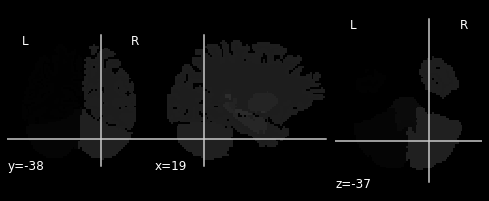

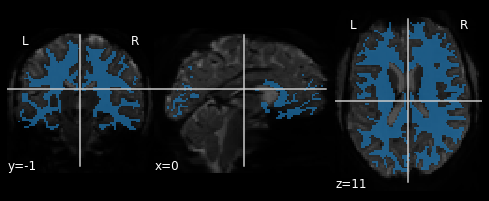

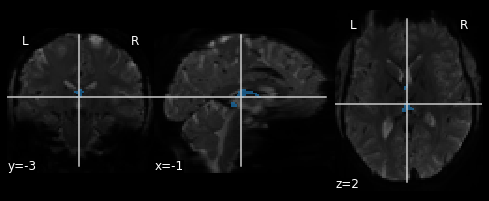

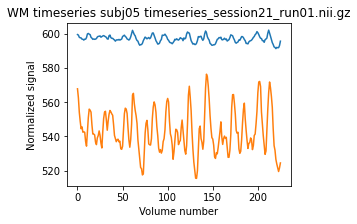

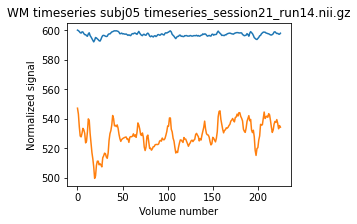

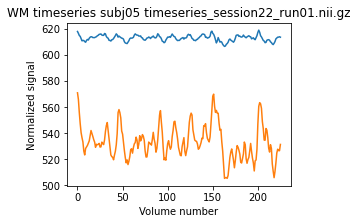

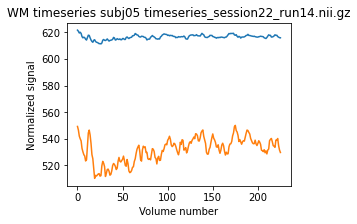

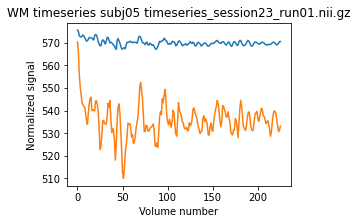

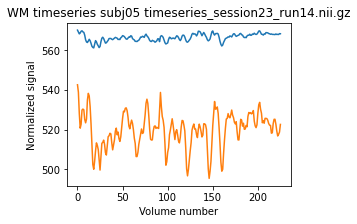

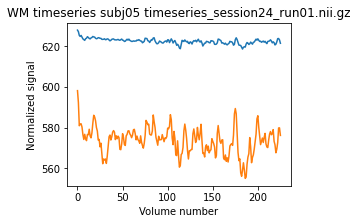

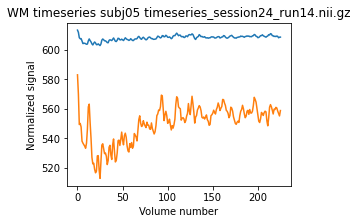

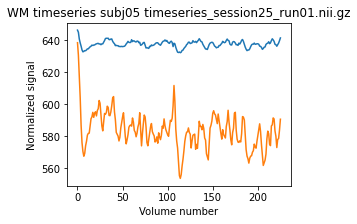

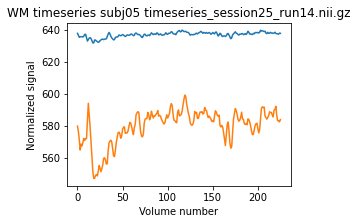

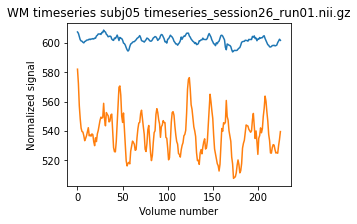

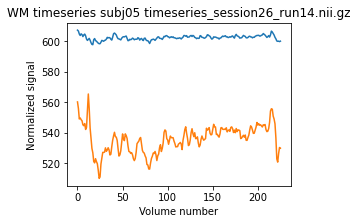

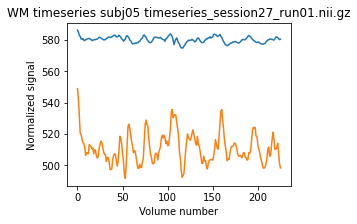

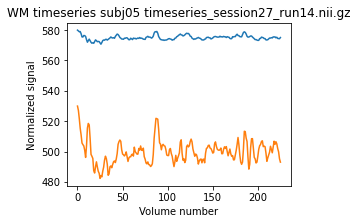

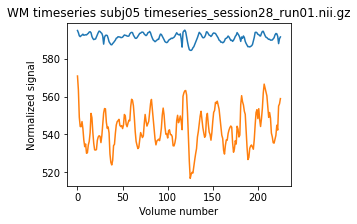

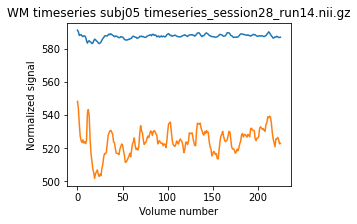

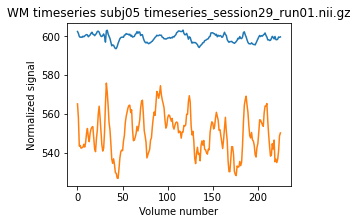

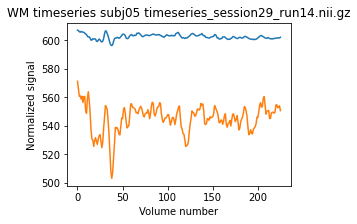

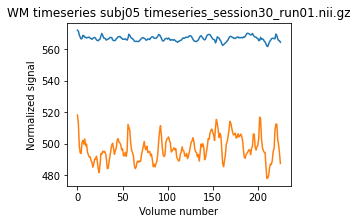

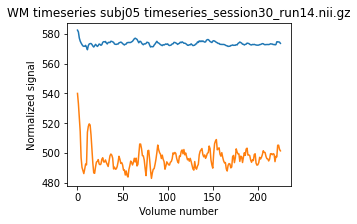

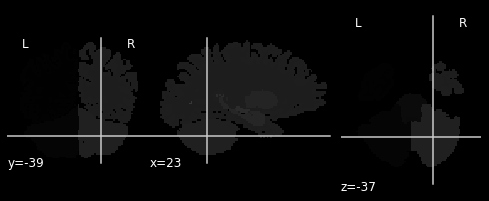

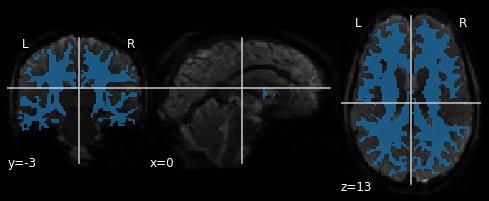

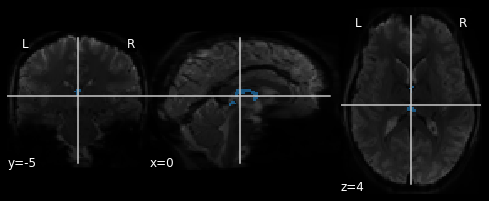

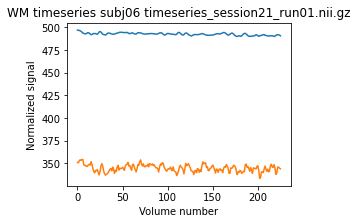

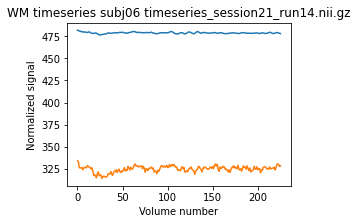

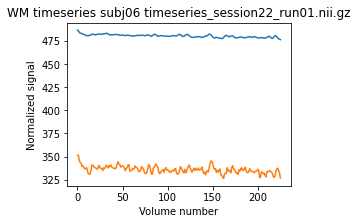

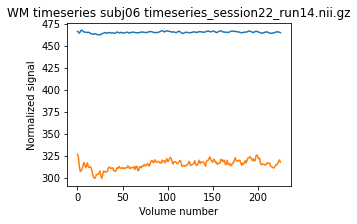

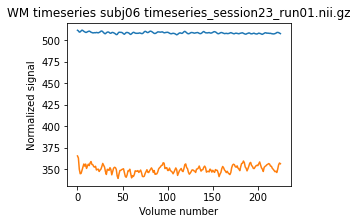

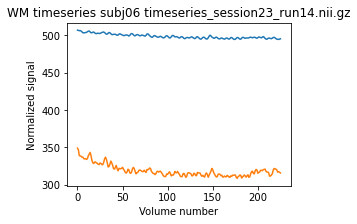

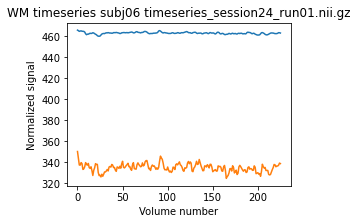

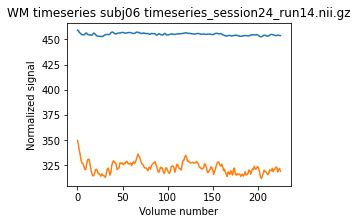

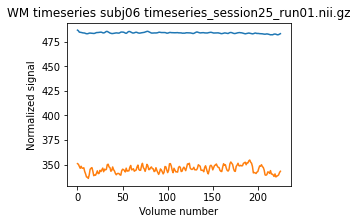

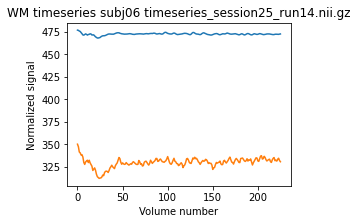

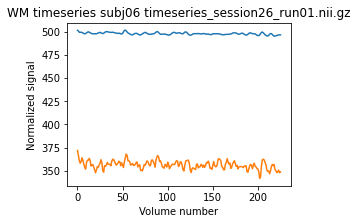

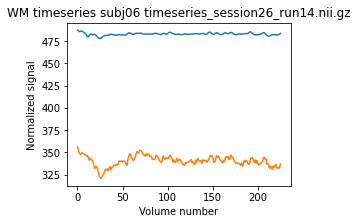

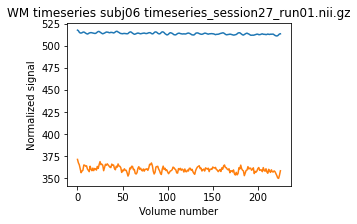

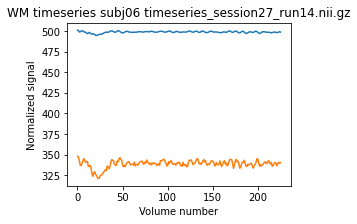

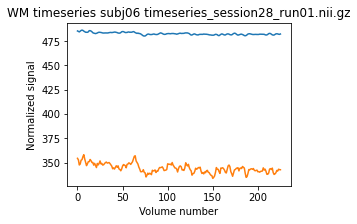

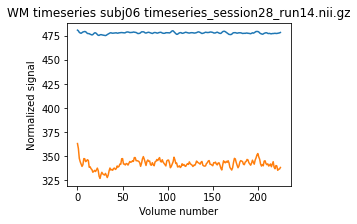

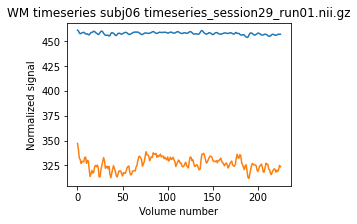

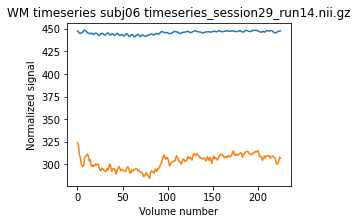

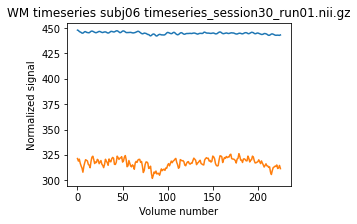

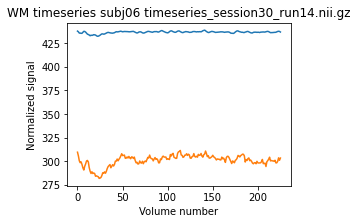

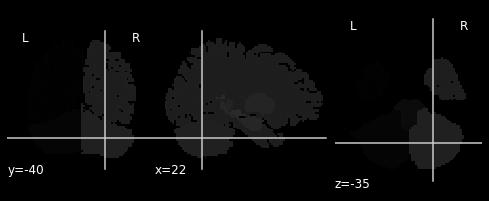

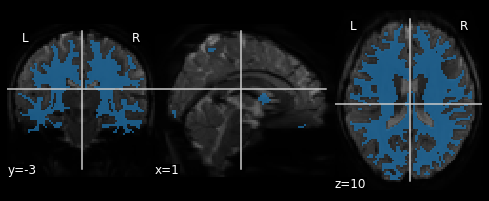

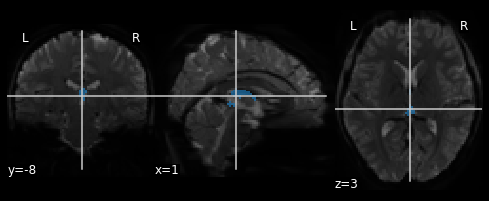

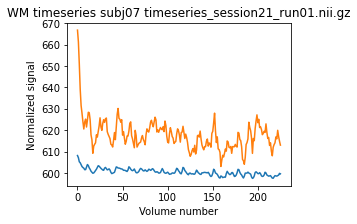

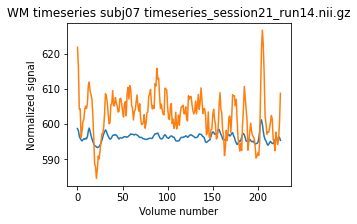

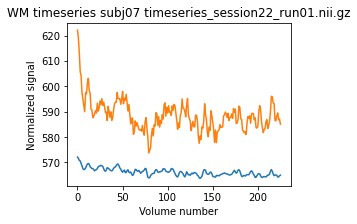

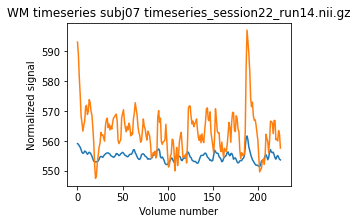

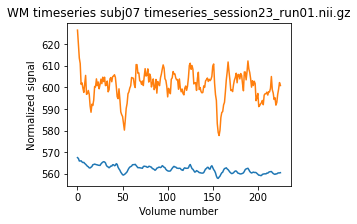

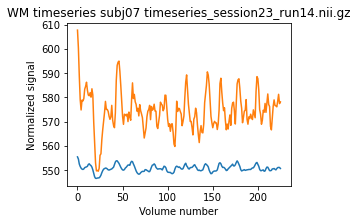

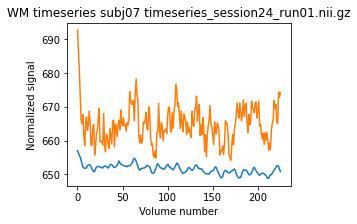

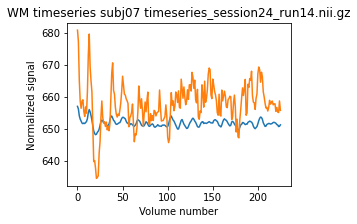

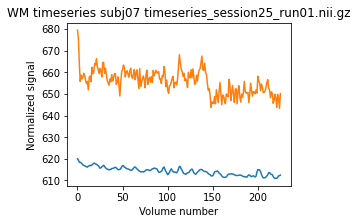

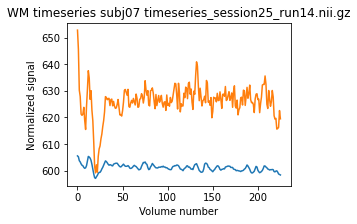

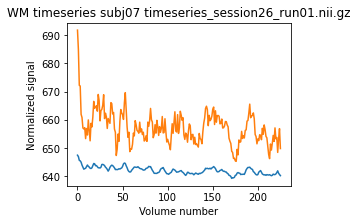

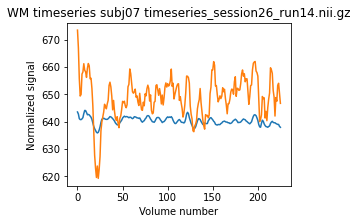

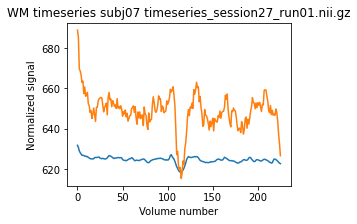

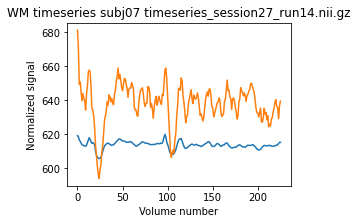

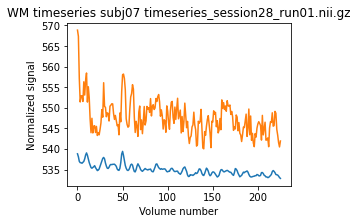

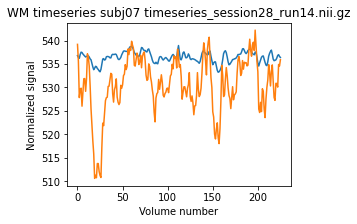

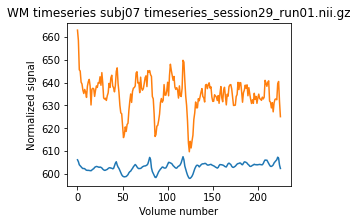

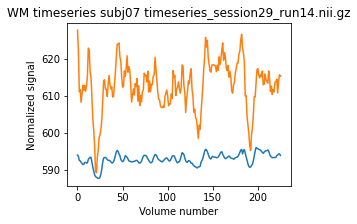

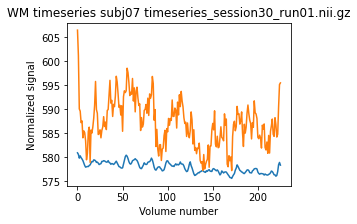

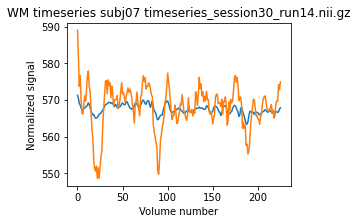

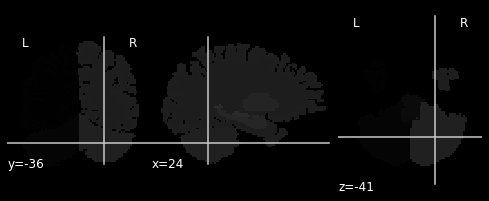

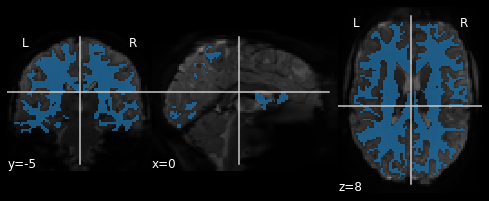

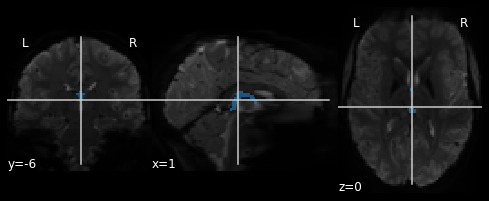

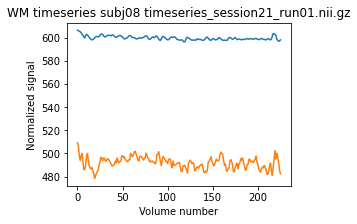

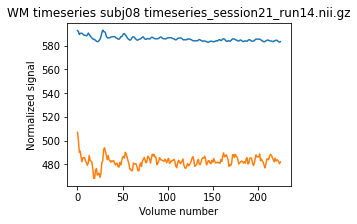

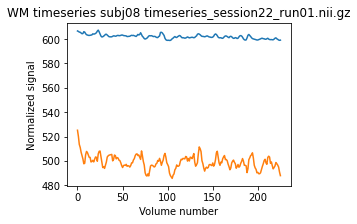

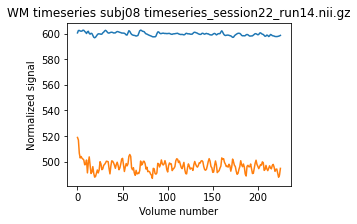

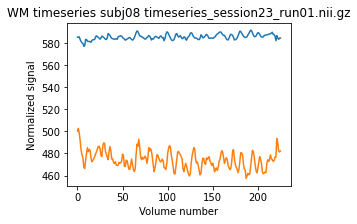

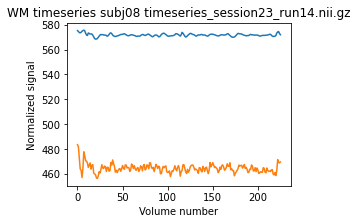

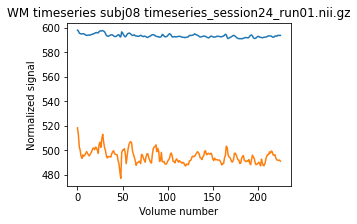

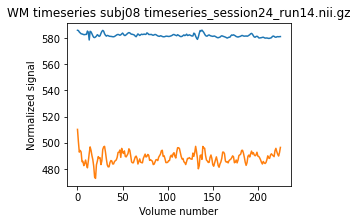

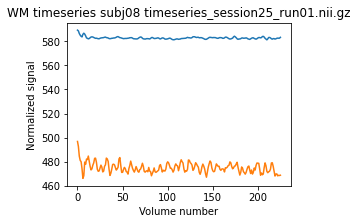

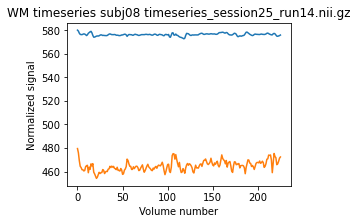

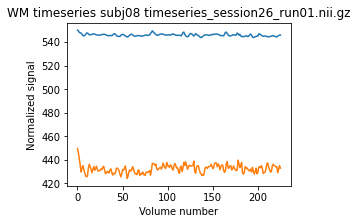

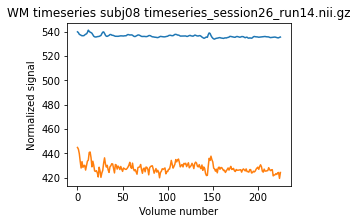

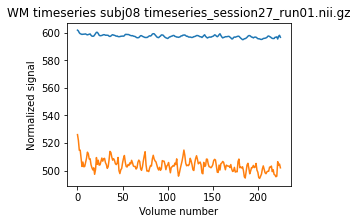

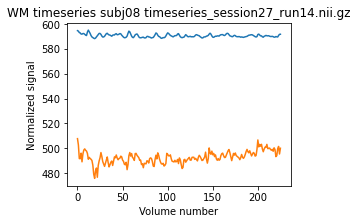

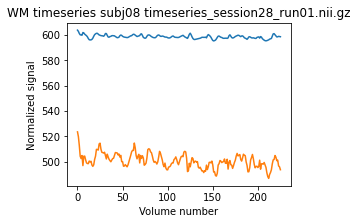

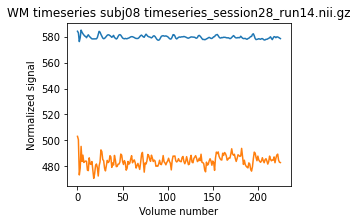

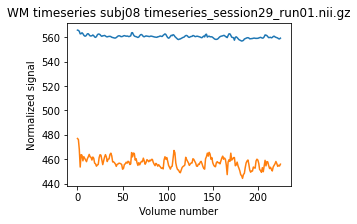

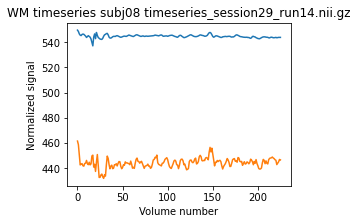

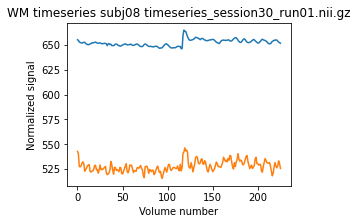

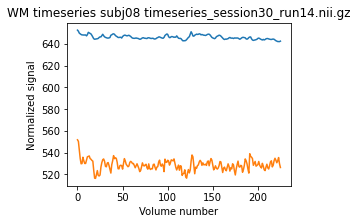

In [7]:
for s,sub in enumerate(subs):
    fssub = fsdir + sub
    bolddir = basedir + sub + '/func1pt8mm/timeseries/'
    confounddir = basedir + sub + '/func1pt8mm/conf/'
    if not os.path.exists(confounddir):
        os.mkdir(confounddir)
     
    asegpath =  nsd_path+ 'nsddata/ppdata/' + sub +'/func1pt8mm/aseg.nii.gz'
    if not os.path.exists(asegpath):
        print('Cant locate ' + asegpath)
        continue
    else:
        print('Loading ' + asegpath)
        aseg = image.load_img(asegpath)
        if doPlot:
            plotting.plot_anat(aseg)
            # Load mean bold image as background for labels
            bg_path = nsd_path + '/nsddata/ppdata/' + sub +'/func1pt8mm/mean.nii.gz'
            bg = image.load_img(bg_path) 

        aseg_data = aseg.get_fdata()
        # create white matter confound regressor (combine both hemispheres)
        wm_data = np.zeros_like(aseg_data)
        wm_data[aseg_data==2]=1
        wm_data[aseg_data==41]=1
        wm_mask = image.new_img_like(aseg,data=wm_data)
        if doPlot:
            plotting.plot_roi(wm_mask,bg_img=bg,cmap='tab20')

        # create CSF confound regressot    
        csf_data = np.zeros_like(aseg_data)
        csf_data[aseg_data==24]=1
        csf_mask = image.new_img_like(aseg,data=csf_data)
        if doPlot:
            plotting.plot_roi(csf_mask,bg_img=bg,cmap='tab20')

        runs = glob.glob(bolddir + '/timeseries*nii.gz')
        runs.sort()
        print('Found ' + str(len(runs)) + ' runs for sub ' + sub)

        for r, run in enumerate(runs):
            boldpath = run
            print('Loading run: ' + run)
            bold = image.load_img(boldpath)
            bold = image.smooth_img(bold, sk)
            print('Applying WM mask')
            wm_signal = masking.apply_mask(bold,wm_mask)
            print('White matter timepoints by voxels:')
            print(wm_signal.shape)
            wm_timeseries = np.mean(wm_signal,axis=1)
            print('Applying CSF mask')
            csf_signal = masking.apply_mask(bold,csf_mask)
            print('CSF timepoints by voxels:')
            print(csf_signal.shape)
            csf_timeseries = np.mean(csf_signal,axis=1)
            if doPlot:
                fig, ax = plt.subplots(figsize =(4, 3))
                ax.plot(np.stack((wm_timeseries,csf_timeseries),axis=1))
                stats.pearsonr(wm_timeseries,csf_timeseries)
                ax.set_title('WM timeseries ' + sub + ' ' + os.path.basename(run))
                ax.set_xlabel('Volume number')
                ax.set_ylabel('Normalized signal')
                print()

            # Save this as a csv
            confounds = np.stack((wm_timeseries,csf_timeseries),axis=1)
            confound_file = str.replace(run,'timeseries','conf')
            confound_file = str.replace(confound_file,'.nii.gz','.tsv')
            print('Saving : ' + confound_file)
            confounds = pd.DataFrame(confounds)
            confounds.columns=("WM","CSF")
            confounds.to_csv(confound_file,sep='\t',index=False)